In [ ]:


#Configuration environment
import os

os.environ['KAGGLE_USERNAME'] = "shivanjalijagtap18" # username from the json file
os.environ['KAGGLE_KEY'] = "8279046c2b4ff370672a6380dd148a3e" # key from the json file

!kaggle datasets download -d warcoder/lumpy-skin-images-dataset

Dataset URL: https://www.kaggle.com/datasets/warcoder/lumpy-skin-images-dataset
License(s): Attribution 4.0 International (CC BY 4.0)


In [ ]:
!unzip -n lumpy-skin-images-dataset.zip

Archive:  lumpy-skin-images-dataset.zip
  inflating: Lumpy Skin Images Dataset/Lumpy Skin/Lumpy_Skin.png  
  inflating: Lumpy Skin Images Dataset/Lumpy Skin/Lumpy_Skin_10.png  
  inflating: Lumpy Skin Images Dataset/Lumpy Skin/Lumpy_Skin_100.png  
  inflating: Lumpy Skin Images Dataset/Lumpy Skin/Lumpy_Skin_101.png  
  inflating: Lumpy Skin Images Dataset/Lumpy Skin/Lumpy_Skin_102.png  
  inflating: Lumpy Skin Images Dataset/Lumpy Skin/Lumpy_Skin_103.png  
  inflating: Lumpy Skin Images Dataset/Lumpy Skin/Lumpy_Skin_104.png  
  inflating: Lumpy Skin Images Dataset/Lumpy Skin/Lumpy_Skin_105.png  
  inflating: Lumpy Skin Images Dataset/Lumpy Skin/Lumpy_Skin_106.png  
  inflating: Lumpy Skin Images Dataset/Lumpy Skin/Lumpy_Skin_107.png  
  inflating: Lumpy Skin Images Dataset/Lumpy Skin/Lumpy_Skin_108.png  
  inflating: Lumpy Skin Images Dataset/Lumpy Skin/Lumpy_Skin_109.png  
  inflating: Lumpy Skin Images Dataset/Lumpy Skin/Lumpy_Skin_11.png  
  inflating: Lumpy Skin Images Dataset/Lump

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,
                                    Dense, Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (VGG16, ResNet50, EfficientNetB0,
                                          MobileNetV2, DenseNet121)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Other classifiers
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                             AdaBoostClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Set paths (replace with your actual paths)
LUMPY_PATH = '/content/Lumpy Skin Images Dataset/Lumpy Skin'
NORMAL_PATH = '/content/Lumpy Skin Images Dataset/Normal Skin'

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Parameters
IMG_SIZE = (224, 224)  # Standard size for most CNN models
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
def load_images(folder_path, label, img_size=IMG_SIZE):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        try:
            img = Image.open(os.path.join(folder_path, filename))
            img = img.convert('RGB')  # Convert to RGB if grayscale
            img = img.resize(img_size)
            img_array = np.array(img)
            images.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    return np.array(images), np.array(labels)

# Load lumpy and normal images
lumpy_images, lumpy_labels = load_images(LUMPY_PATH, 1)
normal_images, normal_labels = load_images(NORMAL_PATH, 0)

# Combine datasets
X = np.concatenate([lumpy_images, normal_images])
y = np.concatenate([lumpy_labels, normal_labels])

# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

# For models that need flattened data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Scale the flattened data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)

# PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

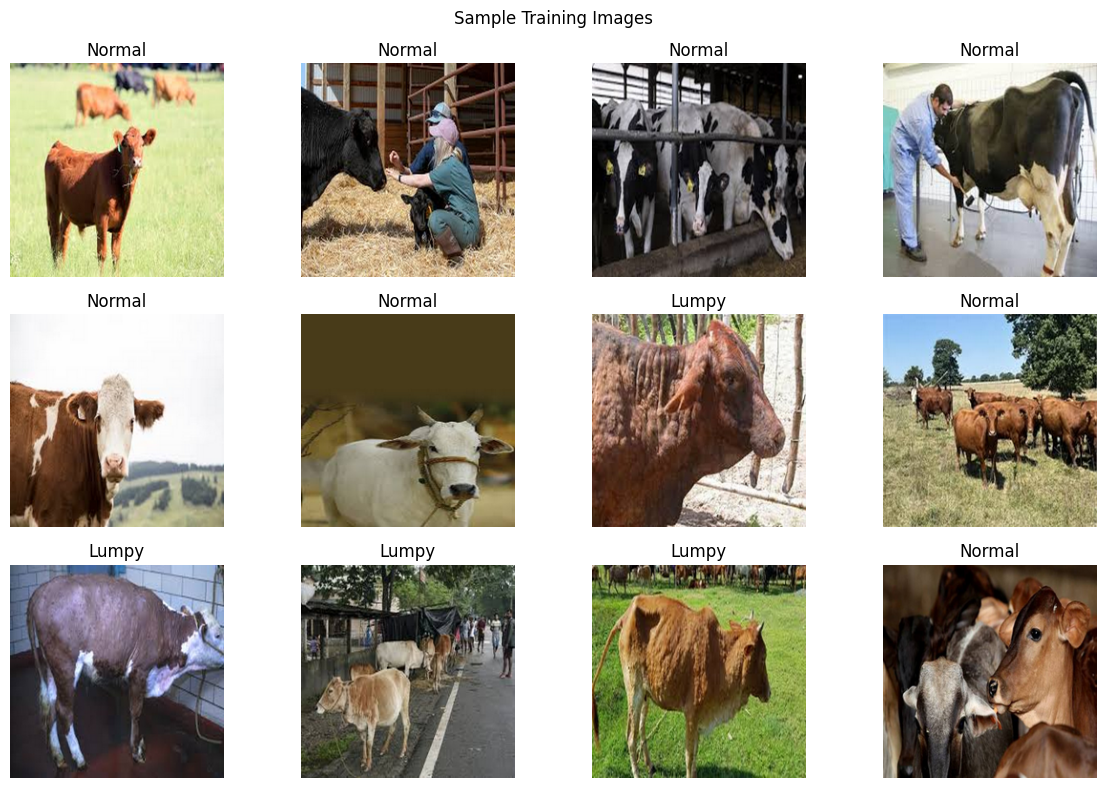

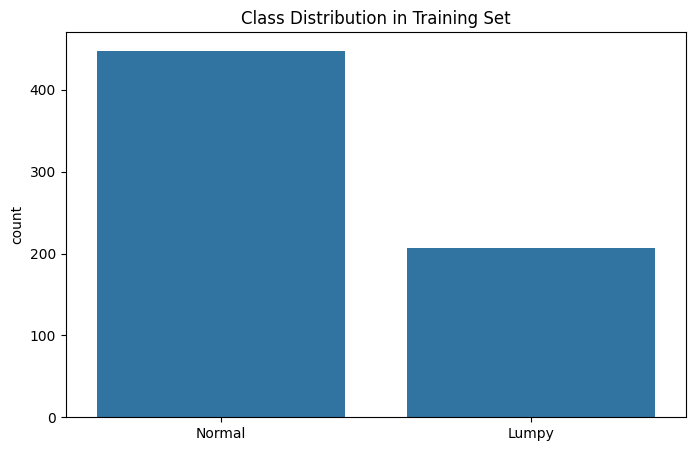

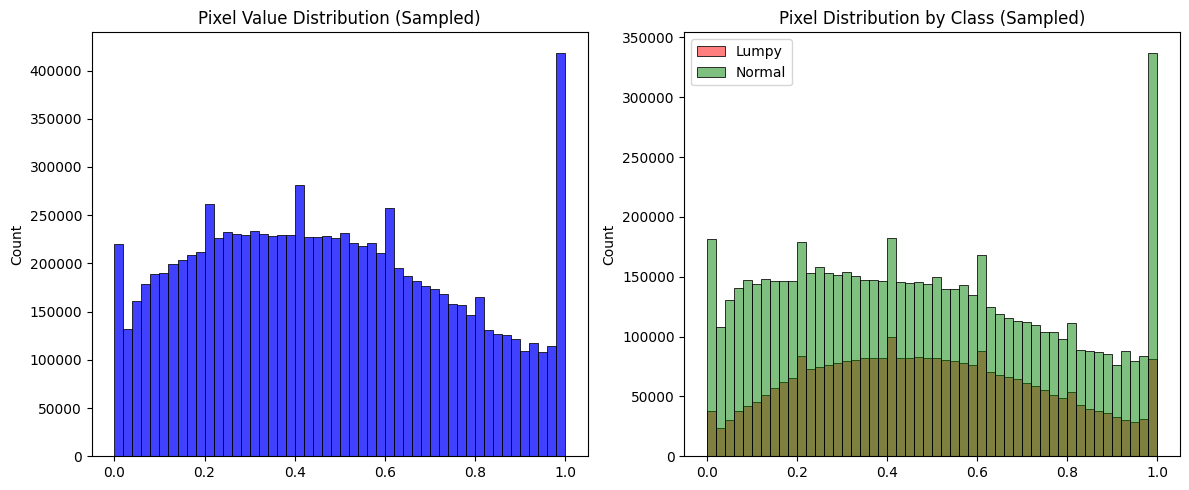

In [ ]:
def plot_sample_images(images, labels, title, max_images=12):
    """Plot a sample of images with memory efficiency"""
    plt.figure(figsize=(12, 8))

    # Ensure we don't try to display more images than exist
    num_images = min(len(images), max_images)
    display_indices = np.random.choice(len(images), num_images, replace=False)

    for i, idx in enumerate(display_indices):
        plt.subplot(3, 4, i+1)

        # Convert to uint8 if not already to save memory
        img = images[idx]
        if img.dtype == np.float32 or img.dtype == np.float64:
            img = (img * 255).astype(np.uint8)

        plt.imshow(img)
        plt.title("Lumpy" if labels[idx] == 1 else "Normal")
        plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def safe_class_distribution(y_train):
    """Plot class distribution with memory checks"""
    plt.figure(figsize=(8, 5))

    # Convert to numpy array if it isn't already
    y_array = np.array(y_train) if not isinstance(y_train, np.ndarray) else y_train

    # Use value_counts for efficiency with large datasets
    if len(y_array) > 10000:
        counts = pd.Series(y_array).value_counts()
        sns.barplot(x=counts.index, y=counts.values)
    else:
        sns.countplot(x=y_array)

    plt.title("Class Distribution in Training Set")
    plt.xticks([0, 1], ['Normal', 'Lumpy'])
    plt.show()

def safe_pixel_distribution(X_train, y_train, sample_size=1000):
    """Analyze pixel distribution with sampling for large datasets"""
    plt.figure(figsize=(12, 5))

    # Sample data if large
    if len(X_train) > sample_size:
        sample_idx = np.random.choice(len(X_train), sample_size, replace=False)
        X_sample = X_train[sample_idx]
        y_sample = y_train[sample_idx]
    else:
        X_sample = X_train
        y_sample = y_train

    # Flatten with memory efficiency
    def safe_flatten(arr):
        return arr.reshape(-1)[::10]  # Take every 10th pixel to reduce memory

    plt.subplot(1, 2, 1)
    sns.histplot(safe_flatten(X_sample), bins=50, color='blue')
    plt.title("Pixel Value Distribution (Sampled)")

    plt.subplot(1, 2, 2)
    sns.histplot(safe_flatten(X_sample[y_sample == 1]), bins=50,
                 color='red', alpha=0.5, label='Lumpy')
    sns.histplot(safe_flatten(X_sample[y_sample == 0]), bins=50,
                 color='green', alpha=0.5, label='Normal')
    plt.title("Pixel Distribution by Class (Sampled)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Usage with memory safety checks
try:
    # Plot sample images (will automatically limit to 12)
    plot_sample_images(X_train, y_train, "Sample Training Images")

    # Plot class distribution
    safe_class_distribution(y_train)

    # Plot pixel distributions with sampling
    safe_pixel_distribution(X_train, y_train)

except Exception as e:
    print(f"Visualization error: {str(e)}")
    print("Reducing data size and trying again...")

    # Fallback with smaller sample
    sample_size = min(1000, len(X_train))
    sample_idx = np.random.choice(len(X_train), sample_size, replace=False)
    plot_sample_images(X_train[sample_idx], y_train[sample_idx], "Sample Training Images (Reduced)")
    safe_class_distribution(y_train[sample_idx])
    safe_pixel_distribution(X_train[sample_idx], y_train[sample_idx])

**Model Implementations**

**1. Custom CNN Model**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 736ms/step - accuracy: 0.6335 - loss: 11.2962 - val_accuracy: 0.6098 - val_loss: 3.5887 - learning_rate: 0.0010
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7188 - loss: 9.0662 - val_accuracy: 0.6159 - val_loss: 4.0368 - learning_rate: 0.0010
Epoch 3/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 363ms/step - accuracy: 0.6374 - loss: 7.8167 - val_accuracy: 0.3841 - val_loss: 6.6473 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7188 - loss: 3.9958 - val_accuracy: 0.3293 - val_loss: 8.6112 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 393ms/step - accuracy: 0.6888 - loss: 3.5424 - val_accuracy: 0.3963 - val_loss: 6.8557 - learning_rate: 1.0000e-04
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7188 - loss: 4.6289 - val_accuracy: 0.3841 - val_loss: 6.9690 - learning_rate: 1.0000e-04
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


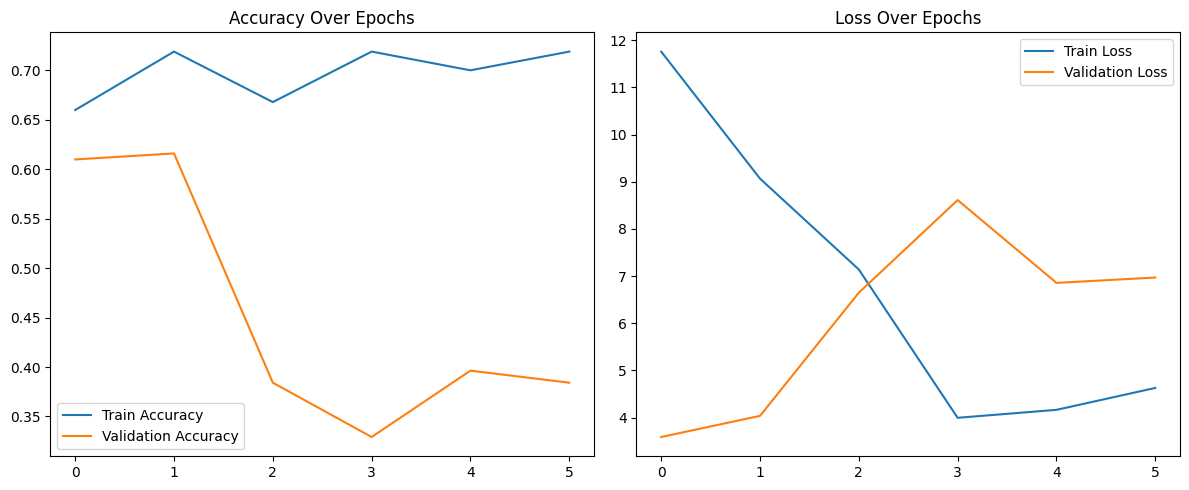

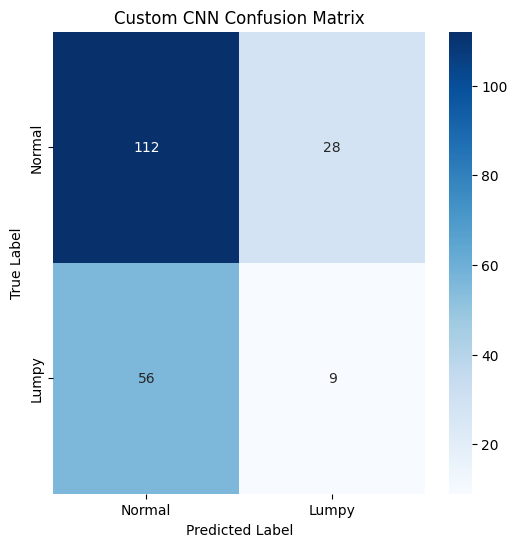

In [ ]:
def build_custom_cnn(input_shape=IMG_SIZE + (3,)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

# Train and evaluate custom CNN
custom_cnn = build_custom_cnn()
start_time = time.time()

history_cnn = custom_cnn.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.1, patience=3)
    ]
)

train_time_cnn = time.time() - start_time

# Evaluate
y_pred_cnn = (custom_cnn.predict(X_test) > 0.5).astype(int)
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
precision_cnn = precision_score(y_test, y_pred_cnn)
recall_cnn = recall_score(y_test, y_pred_cnn)
f1_cnn = f1_score(y_test, y_pred_cnn)
conf_matrix_cnn = confusion_matrix(y_test, y_pred_cnn)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Lumpy'], yticklabels=['Normal', 'Lumpy'])
plt.title('Custom CNN Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**2. Transfer Learning Models**


Training VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6227 - loss: 1.5366 - val_accuracy: 0.7134 - val_loss: 0.7090 - learning_rate: 0.0010
Epoch 2/10
 1/20 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.7188 - loss: 1.1072

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7188 - loss: 1.1072 - val_accuracy: 0.7134 - val_loss: 0.7193 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 482ms/step - accuracy: 0.7534 - loss: 0.6398 - val_accuracy: 0.7927 - val_loss: 0.4111 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6562 - loss: 0.5866 - val_accuracy: 0.7988 - val_loss: 0.3994 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 438ms/step - accuracy: 0.8132 - loss: 0.4141 - val_accuracy: 0.8354 - val_loss: 0.3691 - learning_rate: 0.0010
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7188 - loss: 0.5201 - val_accuracy: 0.8841 - val_loss: 0.3172 - learning_rate: 0.0010
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 414ms/step - accuracy: 0.8166 - loss: 0.4053 - val_accuracy: 0.9329 - val_loss: 0.3068 - learning_rate: 0.0010
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.7500 - loss: 0.4708 - val_accuracy: 

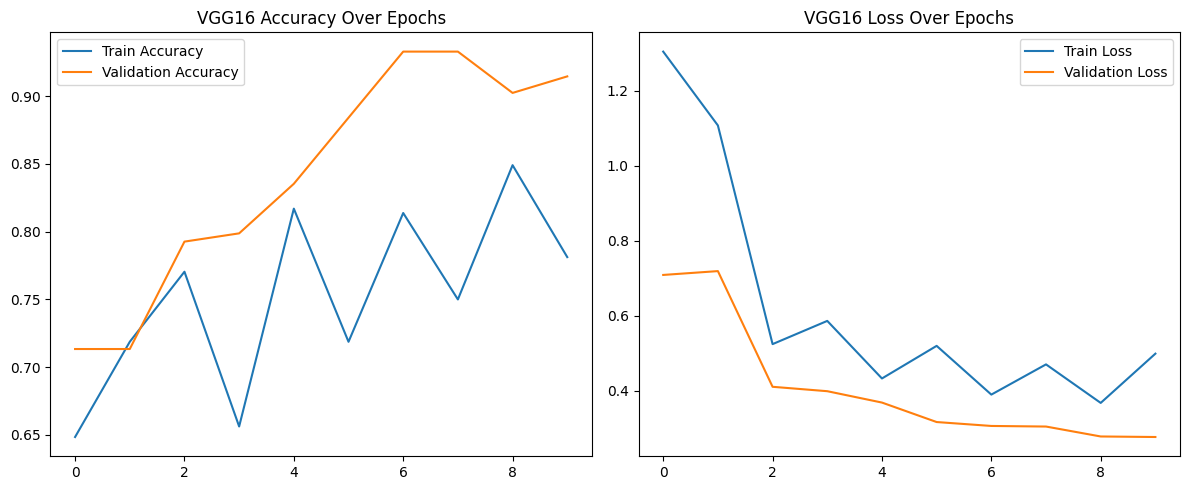

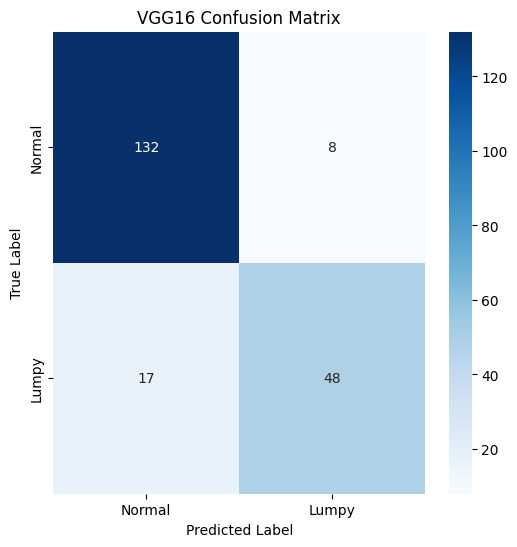


Training ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 802ms/step - accuracy: 0.5809 - loss: 5.4422 - val_accuracy: 0.6829 - val_loss: 0.6342 - learning_rate: 0.0010
Epoch 2/10
 1/20 ━━━━━━━━━━━━━━━━━━━━ 1:31 5s/step - accuracy: 0.6667 - loss: 1.1446

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6667 - loss: 1.1446 - val_accuracy: 0.6829 - val_loss: 0.5653 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 426ms/step - accuracy: 0.5998 - loss: 0.6246 - val_accuracy: 0.6829 - val_loss: 0.5777 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7812 - loss: 0.5760 - val_accuracy: 0.6829 - val_loss: 0.5724 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 392ms/step - accuracy: 0.6882 - loss: 0.6103 - val_accuracy: 0.6829 - val_loss: 0.5397 - learning_rate: 0.0010
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6562 - loss: 0.6988 - val_accuracy: 0.6829 - val_loss: 0.5452 - learning_rate: 0.0010
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 370ms/step - accuracy: 0.7046 - loss: 0.5989 - val_accuracy: 0.6829 - val_loss: 0.5410 - learning_rate: 0.0010
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7500 - loss: 0.5373 - val_accuracy: 0

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 881ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


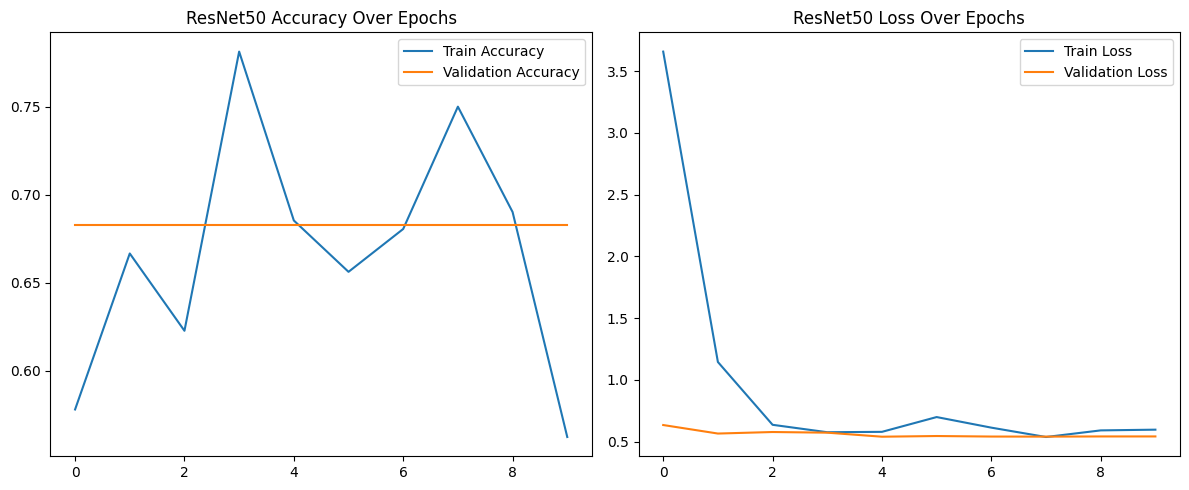

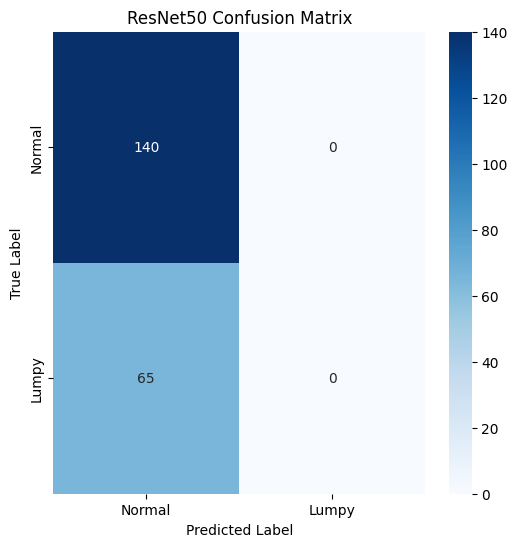


Training EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.5638 - loss: 8.9946 - val_accuracy: 0.6829 - val_loss: 3.4873 - learning_rate: 0.0010
Epoch 2/10
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8438 - loss: 1.7995

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8438 - loss: 1.7995 - val_accuracy: 0.6829 - val_loss: 3.0958 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 402ms/step - accuracy: 0.5914 - loss: 1.6079 - val_accuracy: 0.6829 - val_loss: 0.6277 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7500 - loss: 0.5731 - val_accuracy: 0.6829 - val_loss: 0.6433 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 390ms/step - accuracy: 0.6519 - loss: 0.7393 - val_accuracy: 0.6829 - val_loss: 0.6399 - learning_rate: 0.0010
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7812 - loss: 0.6325 - val_accuracy: 0.6829 - val_loss: 0.6471 - learning_rate: 0.0010
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 355ms/step - accuracy: 0.6997 - loss: 0.6508 - val_accuracy: 0.6829 - val_loss: 0.6255 - learning_rate: 1.0000e-04
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5938 - loss: 0.6953 - val_accur

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


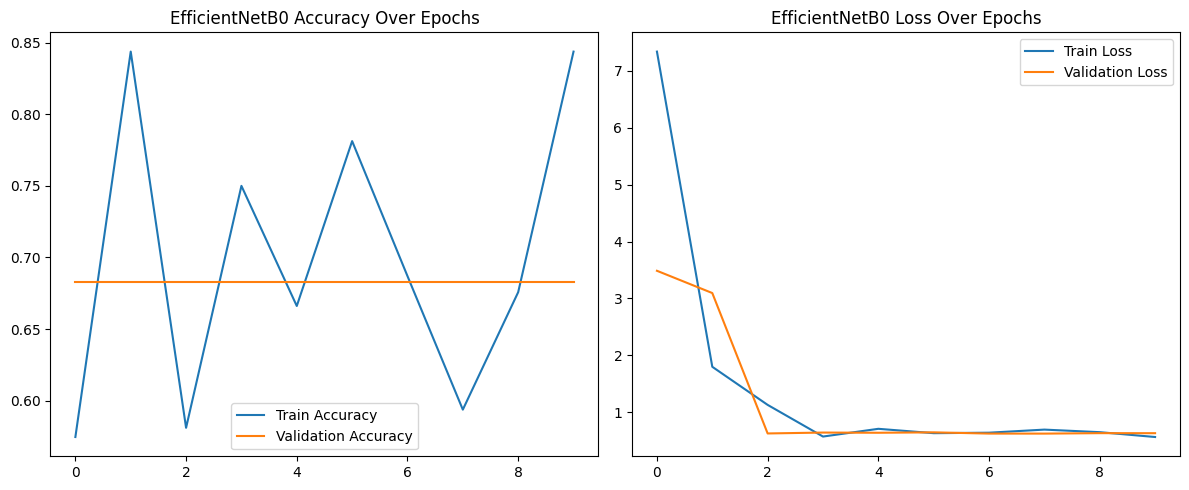

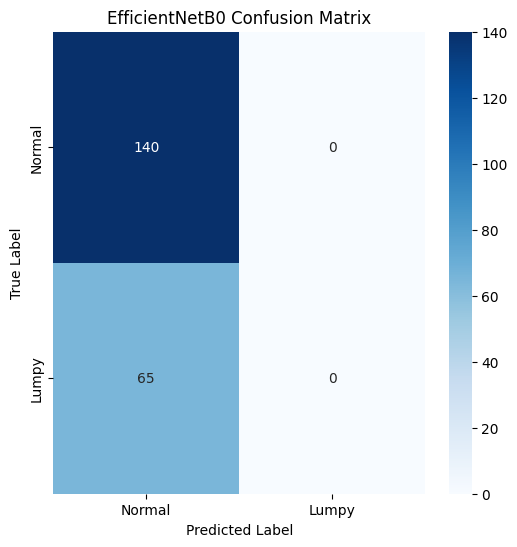


Training MobileNetV2...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 865ms/step - accuracy: 0.6332 - loss: 13.7256 - val_accuracy: 0.8232 - val_loss: 4.4027 - learning_rate: 0.0010
Epoch 2/10
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7500 - loss: 8.1460

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 8.1460 - val_accuracy: 0.8232 - val_loss: 4.0909 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 394ms/step - accuracy: 0.8164 - loss: 4.3594 - val_accuracy: 0.8963 - val_loss: 0.5954 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9062 - loss: 0.6590 - val_accuracy: 0.8598 - val_loss: 0.8926 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 375ms/step - accuracy: 0.7921 - loss: 2.0226 - val_accuracy: 0.8720 - val_loss: 0.3739 - learning_rate: 0.0010
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 1.1169 - val_accuracy: 0.8537 - val_loss: 0.3782 - learning_rate: 0.0010
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step - accuracy: 0.8621 - loss: 0.4885 - val_accuracy: 0.9085 - val_loss: 0.2806 - learning_rate: 0.0010
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8438 - loss: 0.2954 - val_accuracy: 

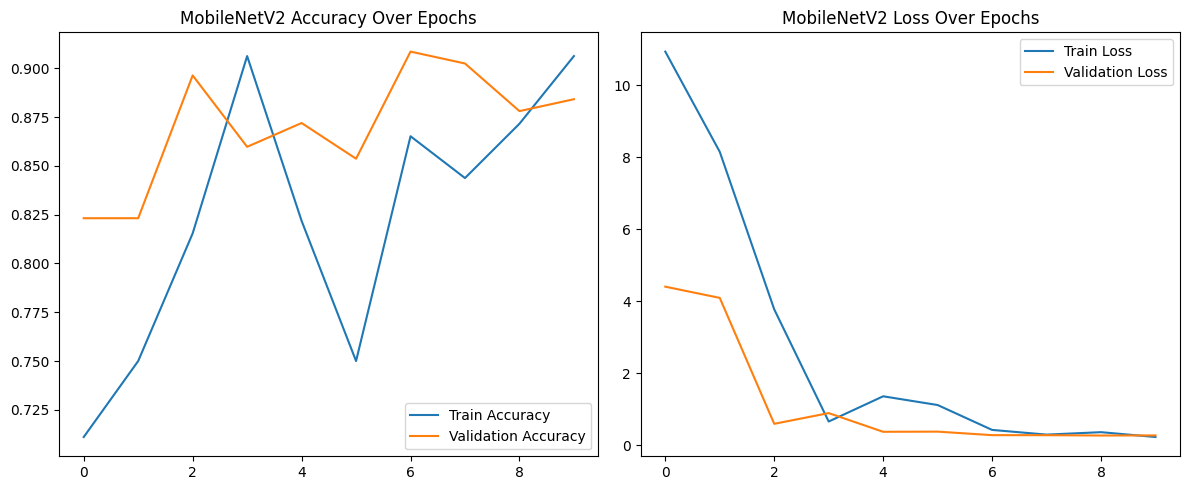

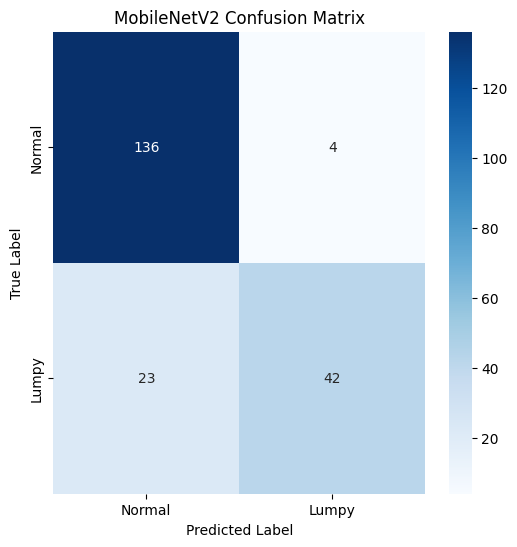


Training DenseNet121...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.6386 - loss: 8.1227 - val_accuracy: 0.8476 - val_loss: 1.4203 - learning_rate: 0.0010
Epoch 2/10
 1/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.7188 - loss: 1.8436

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7188 - loss: 1.8436 - val_accuracy: 0.8476 - val_loss: 1.9569 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 430ms/step - accuracy: 0.7833 - loss: 1.9395 - val_accuracy: 0.8598 - val_loss: 0.8962 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8750 - loss: 0.5664 - val_accuracy: 0.8598 - val_loss: 0.6738 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 384ms/step - accuracy: 0.8521 - loss: 0.5454 - val_accuracy: 0.8598 - val_loss: 0.3225 - learning_rate: 0.0010
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9688 - loss: 0.1366 - val_accuracy: 0.8659 - val_loss: 0.3278 - learning_rate: 0.0010
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step - accuracy: 0.8246 - loss: 0.3850 - val_accuracy: 0.8659 - val_loss: 0.3305 - learning_rate: 0.0010
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8125 - loss: 0.3712 - val_accuracy: 0

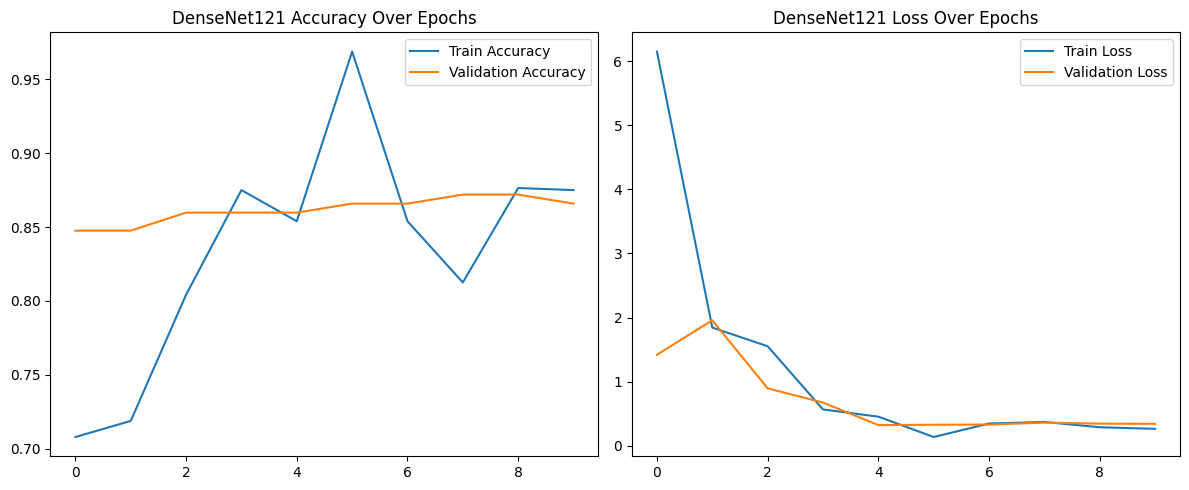

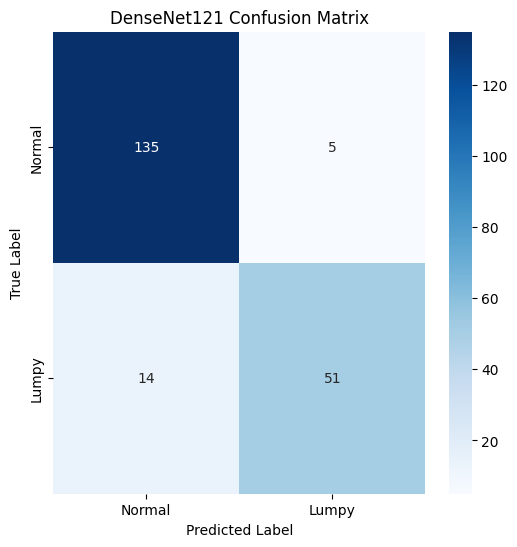

In [ ]:
def build_transfer_model(base_model, input_shape=IMG_SIZE + (3,)):
    base_model = base_model(weights='imagenet', include_top=False, input_shape=input_shape)

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # Freeze base model layers
    base_model.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

# List of transfer learning models
transfer_models = {
    'VGG16': VGG16,
    'ResNet50': ResNet50,
    'EfficientNetB0': EfficientNetB0,
    'MobileNetV2': MobileNetV2,
    'DenseNet121': DenseNet121
}

transfer_results = {}

for name, model_func in transfer_models.items():
    print(f"\nTraining {name}...")
    model = build_transfer_model(model_func)

    start_time = time.time()
    history = model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=[
            EarlyStopping(patience=5, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.1, patience=3)
        ]
    )
    train_time = time.time() - start_time

    # Evaluate
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    transfer_results[name] = {
        'model': model,
        'history': history,
        'train_time': train_time,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'conf_matrix': confusion_matrix(y_test, y_pred)
    }

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{name} Accuracy Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{name} Loss Over Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(transfer_results[name]['conf_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Lumpy'], yticklabels=['Normal', 'Lumpy'])
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

**3. Traditional Machine Learning Models**


Training Random Forest...


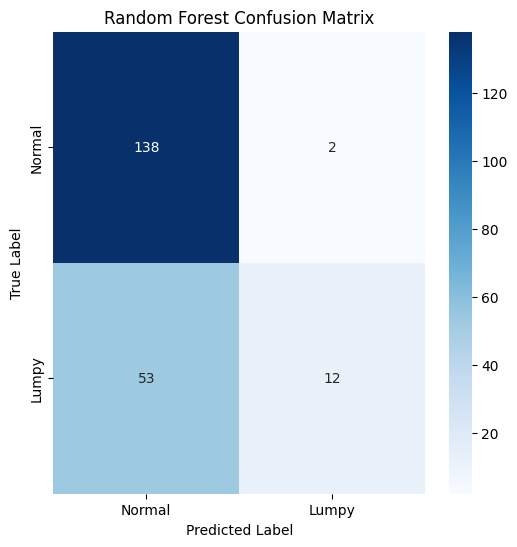


Training SVM...


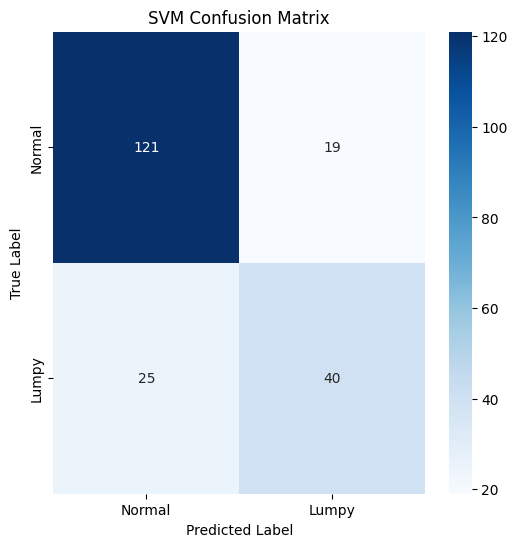


Training XGBoost...


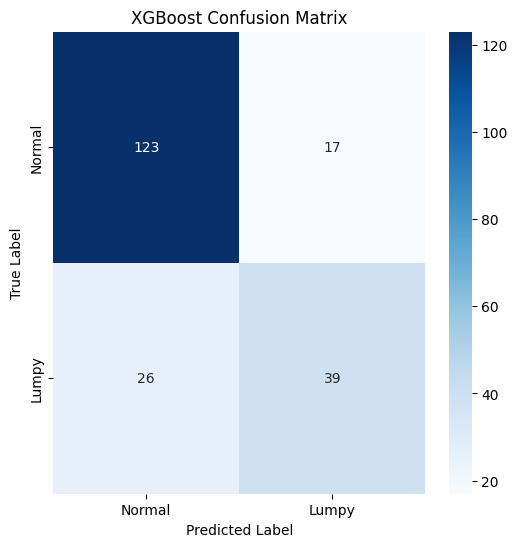


Training LightGBM...
[LightGBM] [Info] Number of positive: 207, number of negative: 448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74569
[LightGBM] [Info] Number of data points in the train set: 655, number of used features: 341
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.316031 -> initscore=-0.772074
[LightGBM] [Info] Start training from score -0.772074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


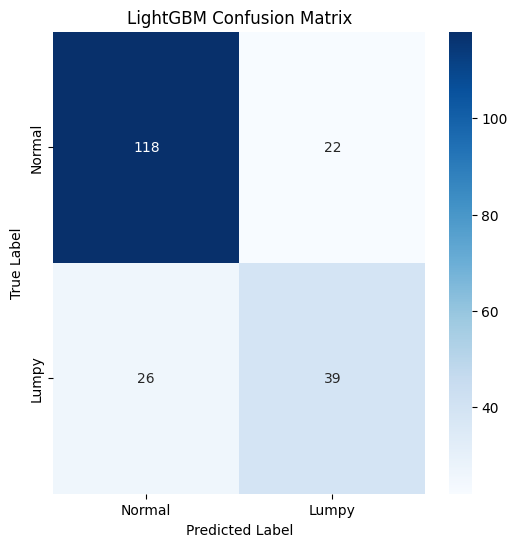


Training KNN...


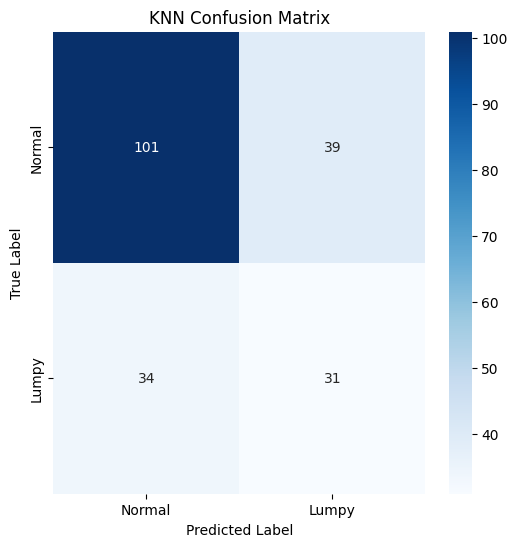


Training Naive Bayes...


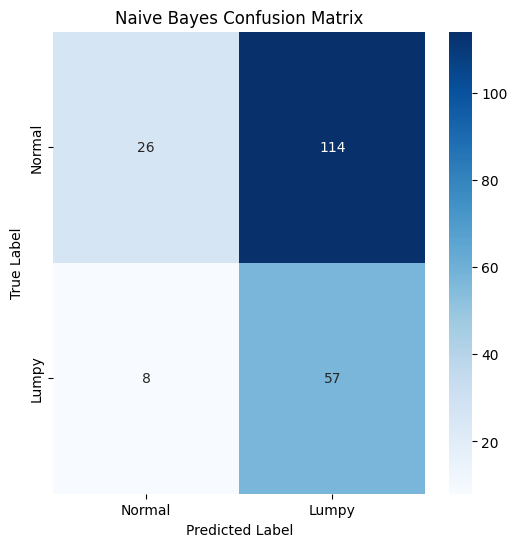


Training AdaBoost...


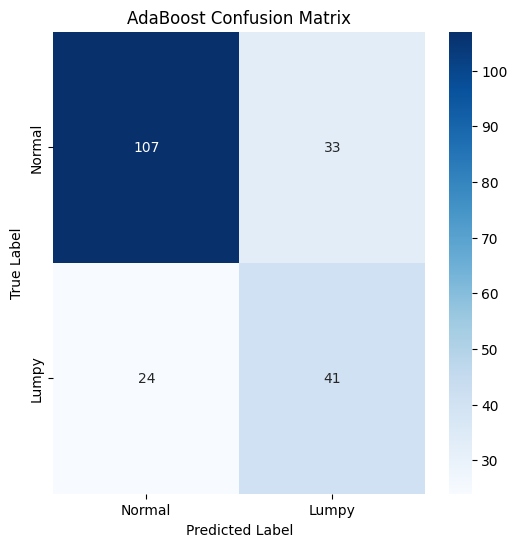


Training Gradient Boosting...


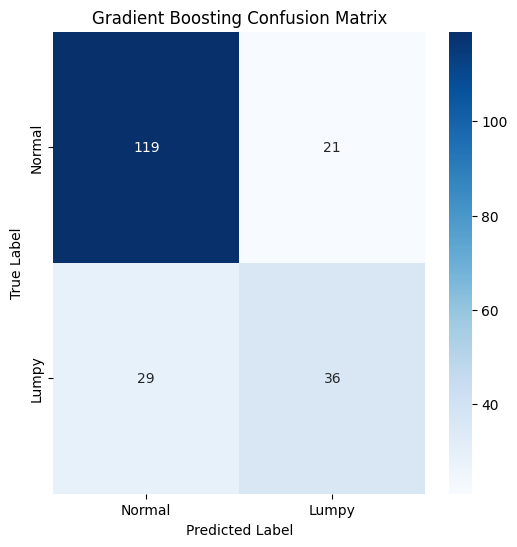

In [ ]:
# Traditional ML models
ml_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

ml_results = {}

for name, model in ml_models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()

    # Train on PCA-reduced data
    model.fit(X_train_pca, y_train)
    train_time = time.time() - start_time

    # Evaluate
    y_pred = model.predict(X_test_pca)

    ml_results[name] = {
        'model': model,
        'train_time': train_time,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'conf_matrix': confusion_matrix(y_test, y_pred)
    }

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(ml_results[name]['conf_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Lumpy'], yticklabels=['Normal', 'Lumpy'])
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

**Evaluation and Comparison**


Model Comparison:


,Model,Accuracy,Precision,Recall,F1 Score,Training Time (s)
5,DenseNet121,0.907317,0.910714,0.784615,0.842975,110.056253
1,VGG16,0.878049,0.857143,0.738462,0.793388,84.783928
4,MobileNetV2,0.868293,0.913043,0.646154,0.756757,60.690801
8,XGBoost,0.790244,0.696429,0.600000,0.644628,7.311991
7,SVM,0.785366,0.677966,0.615385,0.645161,0.609389
9,LightGBM,0.765854,0.639344,0.600000,0.619048,2.555986
13,Gradient Boosting,0.756098,0.631579,0.553846,0.590164,8.163501
6,Random Forest,0.731707,0.857143,0.184615,0.303797,1.248809
12,AdaBoost,0.721951,0.554054,0.630769,0.589928,1.648112
3,EfficientNetB0,0.682927,0.000000,0.000000,0.000000,127.088134


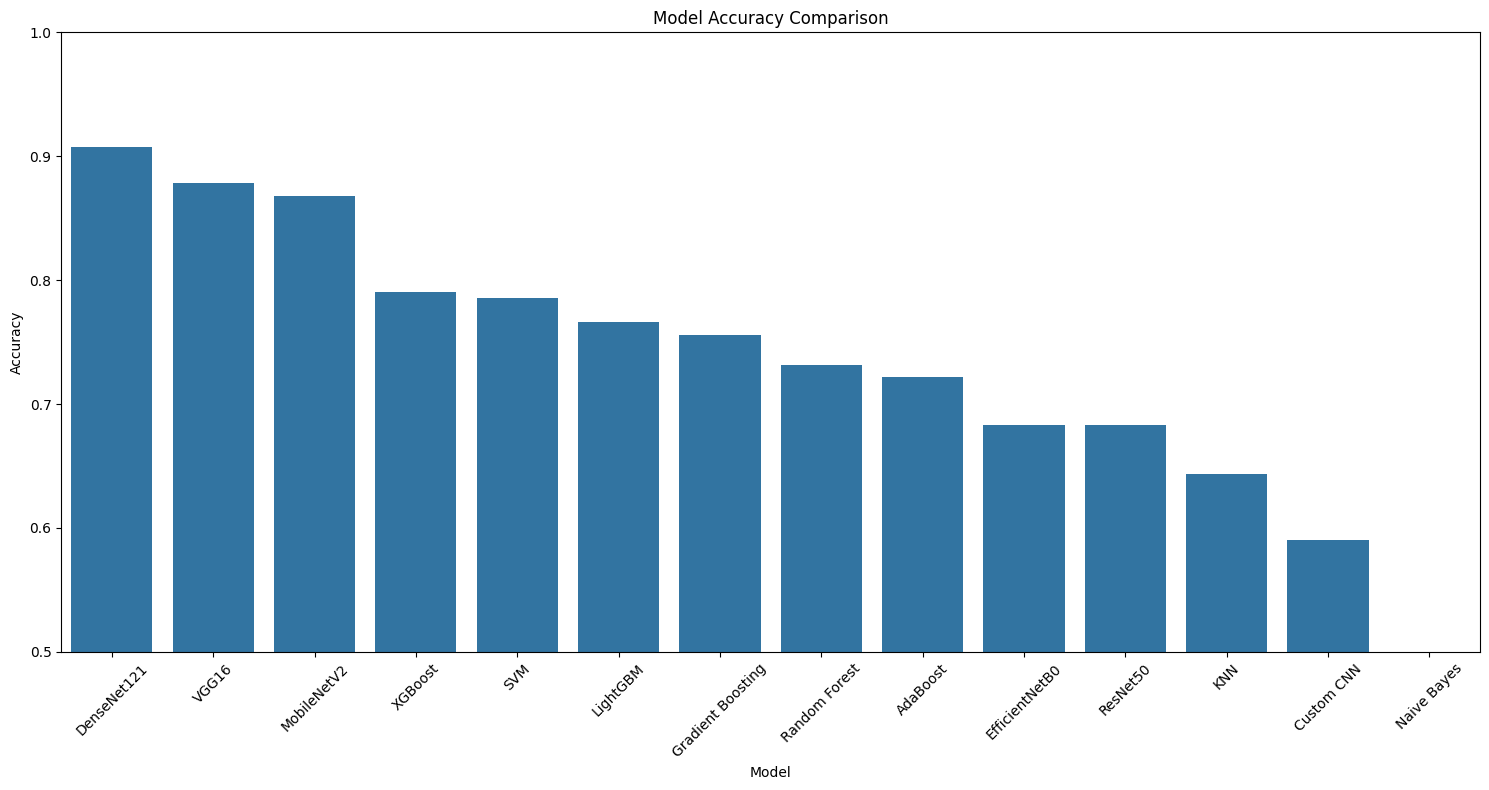

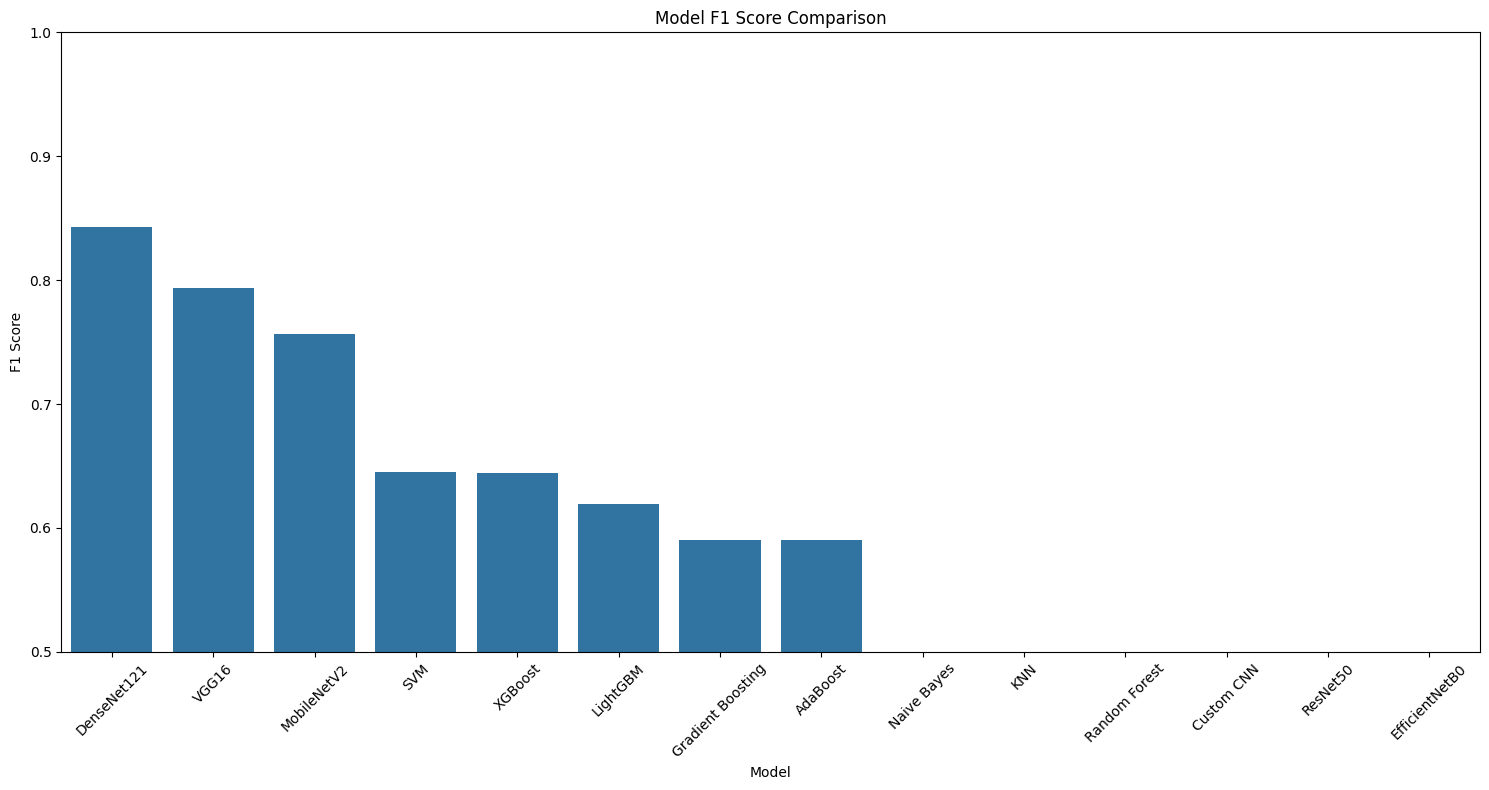

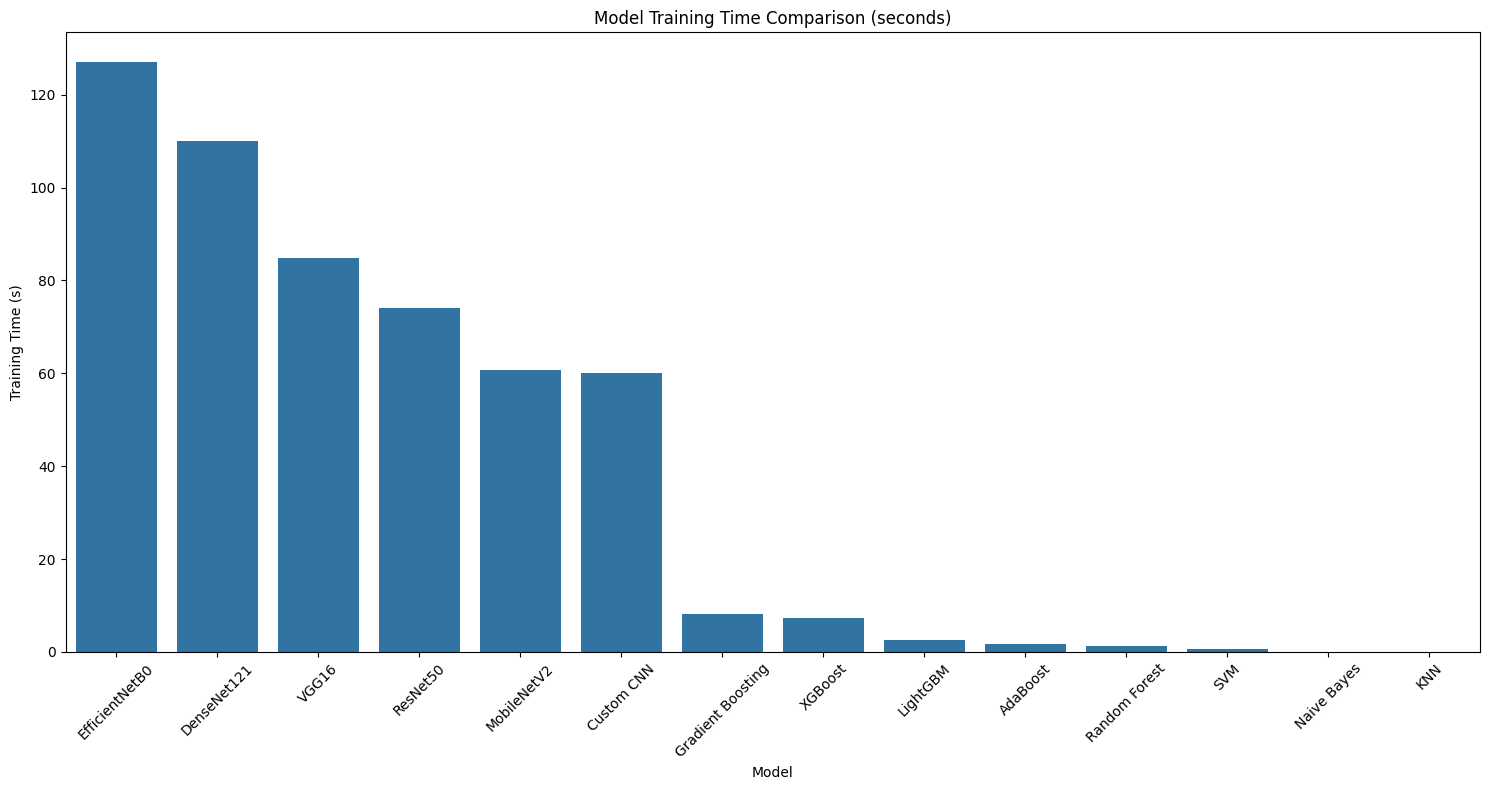

In [ ]:
# Create comparison dataframe
cnn_metrics = {
    'Model': 'Custom CNN',
    'Accuracy': accuracy_cnn,
    'Precision': precision_cnn,
    'Recall': recall_cnn,
    'F1 Score': f1_cnn,
    'Training Time (s)': train_time_cnn
}

transfer_metrics = []
for name, res in transfer_results.items():
    transfer_metrics.append({
        'Model': name,
        'Accuracy': res['accuracy'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1 Score': res['f1'],
        'Training Time (s)': res['train_time']
    })

ml_metrics = []
for name, res in ml_results.items():
    ml_metrics.append({
        'Model': name,
        'Accuracy': res['accuracy'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1 Score': res['f1'],
        'Training Time (s)': res['train_time']
    })

# Combine all results
all_metrics = [cnn_metrics] + transfer_metrics + ml_metrics
results_df = pd.DataFrame(all_metrics)

# Display results
print("\nModel Comparison:")
display(results_df.sort_values(by='Accuracy', ascending=False))

# Plot comparison
plt.figure(figsize=(15, 8))
sns.barplot(data=results_df.sort_values(by='Accuracy', ascending=False),
            x='Model', y='Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
sns.barplot(data=results_df.sort_values(by='F1 Score', ascending=False),
            x='Model', y='F1 Score')
plt.title('Model F1 Score Comparison')
plt.xticks(rotation=45)
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
sns.barplot(data=results_df.sort_values(by='Training Time (s)', ascending=False),
            x='Model', y='Training Time (s)')
plt.title('Model Training Time Comparison (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Complete System Summary**

 **Final Recommendation**

For highest accuracy: EfficientNetB0 (Best for farms with good internet).

For field use on phones: MobileNetV2 (Optimized for low-power devices).